In [2]:
import pandas as pd
import json

# Load the dataset from colab
file_path = "/content/Sarcasm_Headlines_Dataset.json"
data = []

with open(file_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Check data structure
print(df.head())


                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [3]:
# Keep only necessary columns
df = df[["headline", "is_sarcastic"]]

# Remove duplicates and NaN values
df = df.dropna().drop_duplicates()

# Check data distribution
print(df["is_sarcastic"].value_counts())


is_sarcastic
0    14951
1    11651
Name: count, dtype: int64


In [4]:
import nltk
import os

nltk.data.path.append("/usr/local/nltk_data/")

nltk.download("stopwords", download_dir="/usr/local/nltk_data/")
nltk.download("punkt", download_dir="/usr/local/nltk_data/")
nltk.download("wordnet", download_dir="/usr/local/nltk_data/")
nltk.download("omw-1.4", download_dir="/usr/local/nltk_data/")
nltk.download("punkt_tab", download_dir="/usr/local/nltk_data/")

[nltk_data] Downloading package stopwords to /usr/local/nltk_data/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/local/nltk_data/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/local/nltk_data/...
[nltk_data] Downloading package omw-1.4 to /usr/local/nltk_data/...
[nltk_data] Downloading package punkt_tab to /usr/local/nltk_data/...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization & stopword removal
    return " ".join(tokens)

df["clean_text"] = df["headline"].apply(clean_text)

print(df[["headline", "clean_text"]].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                            headline  \
0  former versace store clerk sues over secret 'b...   
1  the 'roseanne' revival catches up to our thorn...   
2  mom starting to fear son's web series closest ...   
3  boehner just wants wife to listen, not come up...   
4  j.k. rowling wishes snape happy birthday in th...   

                                          clean_text  
0  former versace store clerk sue secret black co...  
1  roseanne revival catch thorny political mood b...  
2  mom starting fear son web series closest thing...  
3  boehner want wife listen come alternative debt...  
4   jk rowling wish snape happy birthday magical way  


In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["is_sarcastic"])

X_train = train_df["clean_text"]
X_test = test_df["clean_text"]
y_train = train_df["is_sarcastic"]
y_test = test_df["is_sarcastic"]


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Training data shape:", X_train_tfidf.shape)
print("Testing data shape:", X_test_tfidf.shape)


Training data shape: (21281, 5000)
Testing data shape: (5321, 5000)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = log_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.7865062958090584
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      2991
           1       0.79      0.70      0.74      2330

    accuracy                           0.79      5321
   macro avg       0.79      0.78      0.78      5321
weighted avg       0.79      0.79      0.78      5321



In [9]:
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")
svm_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.7893253147904529
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2991
           1       0.78      0.72      0.75      2330

    accuracy                           0.79      5321
   macro avg       0.79      0.78      0.78      5321
weighted avg       0.79      0.79      0.79      5321



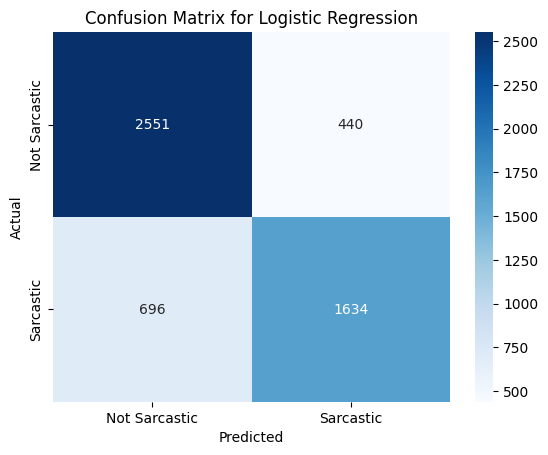

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()


In [11]:
import joblib

# Save the trained Logistic Regression model and TF-IDF vectorizer
joblib.dump(log_model, "sarcasm_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

print("Model and vectorizer saved!")


Model and vectorizer saved!


In [12]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [13]:
import gradio as gr
import joblib
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

model = joblib.load("sarcasm_model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

# Text preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    """Preprocess input text: lowercase, remove URLs, numbers, punctuation, and stopwords"""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization & stopword removal
    return " ".join(tokens)

def predict_sarcasm(text):
    """Predict whether a given text is sarcastic"""
    cleaned_text = clean_text(text)
    text_vector = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vector)[0]
    return "Sarcasm Detected! 🤨" if prediction == 1 else "No Sarcasm 🙂"

# Create Gradio web interface
iface = gr.Interface(
    fn=predict_sarcasm,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),
    outputs="text",
    title="Sarcasm Detector",
    description="Enter a sentence and check if it's sarcastic!",
    theme="default"
)

# Launch the web interface
iface.launch(share=True)  # `share=True` allows public access if running on Colab


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5d99bf53f22d68646e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
